# Homework 6 Q2
In this question, we will be analyzing blood cell images! There will be 3 classes: basophil, eosinophil, and neutrophil. Your job is to write convolutional neural networks to classify these images as accurately as you can.

## Load and Preprocess Image Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from PIL import Image
import random

Let's quickly write down our class indices for consistency throughout the program!

In [22]:
classes = ["basophil", "eosinophil", "neutrophil"]
class2idx = {"basophil" : 0, "eosinophil" : 1, "neutrophil" : 2}
idx2class = {0 : "basophil", 1 : "eosinophil", 2 : "neutrophil"}

We will gather all the file names now and shuffle them...

In [23]:
file_path = "/content/drive/MyDrive/BIOE245_HW6/bloodcells_dataset/"     # make sure it ends with bloodcells_dataset/ so we can access the different subfolders
baso = [f for f in listdir(file_path + "basophil") if isfile(join(file_path + "basophil", f)) and f != ".DS_Store"]
eosi = [f for f in listdir(file_path + "eosinophil") if isfile(join(file_path + "eosinophil", f)) and f != ".DS_Store"]
neutro = [f for f in listdir(file_path + "neutrophil") if isfile(join(file_path + "neutrophil", f)) and f != ".DS_Store"]
data = baso + eosi + neutro
random.shuffle(data)

We will build a class called `BloodCell_Dataset`, a subclass of PyTorch's `torch.utils.data.Dataset`. All subclasses need to define 3 methods: `__init__()`, `__len__()`, and `__getitem__()`.


*   `__init__()`: Takes in the file path of the image folders, the list of file names we just gathered, and one of two modes - `train` or `test`. If the mode is `train`, then we will create the training test. If the mode is `test`, the entire testing data will be fetched at once to save time as we don't have that many testing images.
*   `__len__()`: Returns the length of the dataset, # of samples.
*   `__getitem__()`: Gets an input `i` and returns a tuple of `(data[i], label[i])`. In this method, we will only read the image from the disk every time a sample is requested. This helps us save an enourmous amount of space and can ensure CUDA out of memory errors never happening. This method also does some quick preprocessing, it makes sure that all images are of size `(3, 363, 360)`.

In the future when you handle large datasets, you will very likely need to handle it with this fashion. If we were to fetch ALL our images from disk, we will likely run out of memory very quickly because we are dealing with high resolution images.



In [24]:
class BloodCell_Dataset(Dataset):
    def __init__(self, file_path, file_path_list, mode="train", test_size=0.2):
        self.file_path = file_path
        self.classes = ["basophil", "eosinophil", "neutrophil"]
        self.class2idx = {"basophil" : 0, "eosinophil" : 1, "neutrophil" : 2}
        self.idx2class = {0 : "basophil", 1 : "eosinophil", 2 : "neutrophil"}
        self.data = file_path_list
        assert mode in ['train', 'test'], f'mode needs to be either train or test, but it\'s {mode}'
        partition = int(len(self.data) * (1 - test_size))
        if mode == 'train':
            self.data = self.data[:partition]
        else:
            self.data = self.data[partition:]
            self.tensor_imgs = []
            self.labels = []
            for i in range(len(self.data)):
                img, label = self.__getitem__(i)                                # if we're creating the test set, we can just fetch all images
                if len(img.shape) == 3:                                         # at once because the test set size is usually much smaller
                    img = img.unsqueeze(0)                                      # of course this may not ALWAYS be the case...
                self.tensor_imgs.append(img)
                self.labels.append(label.item())

            self.tensor_imgs = torch.cat(self.tensor_imgs, dim=0).type(torch.float32)
            self.labels = torch.tensor(self.labels).type(torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        file_name = self.data[i]

        if "SNE" in file_name or "NEU" in file_name or "BNE" in file_name:      # each file name tells us whether the image is class 0, 1, or 2
            label = 2                                                           # so that's how we keep track of our labels
        elif "EO" in file_name:
            label = 1
        elif "BA" in file_name:
            label = 0

        convert_tensor = transforms.ToTensor()                                  
        path = self.file_path + self.idx2class[label] + "/" + file_name     
        img = Image.open(path)      
        tensor_img = convert_tensor(img)                                        # converts image to 3D torch.Tensor
        if tensor_img.shape != (3, 363, 360):
            tensor_img = tensor_img[:, 3:366, 3:363]                            # quick crop and reshape if the image is not uniform
        return tensor_img.type(torch.float32), torch.tensor(label).type(torch.long)
    
    def get_test(self):
        return self.tensor_imgs, self.labels

Use the class we wrote to create 2 datasets. The creation of `testing_data` will take slightly longer because we are fetching the entire testing set into our memory. This method should take approximately 1 minute.

In [25]:
training_data = BloodCell_Dataset(file_path, data, mode='train')
testing_data = BloodCell_Dataset(file_path, data, mode='test')

Let's look at the training and testing set size...

In [26]:
print(f"Size of training_data:\t{len(training_data)}")
print(f"Size of testing_data:\t{len(testing_data)}")

Size of training_data:	390
Size of testing_data:	98


Inspect the dimension before we start building our model.

In [27]:
test, test_label = testing_data.get_test()
print(test.shape)
print(test_label.shape)

torch.Size([98, 3, 363, 360])
torch.Size([98])


Wonderful! Now, our images are all of size `(3, 363, 360)`. As you have probably guessed, our images have 3 channels (RGB channels) with height of 363 pixels and width of 360 pixels (homework 5's FashionMNIST images had 28 by 28 pixels). Also, PyTorch prefers the number of channels in the first dimension (second dimension if we include batch size, such as `(N, 3, 363, 360)`).

Let's quickly visualize our data!

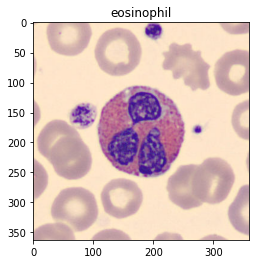

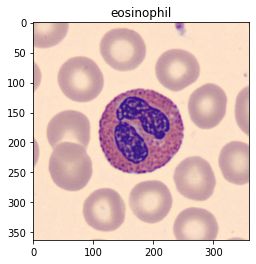

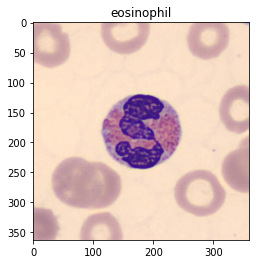

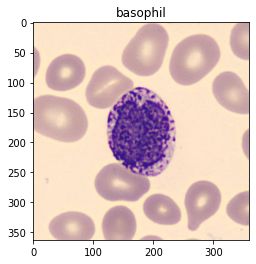

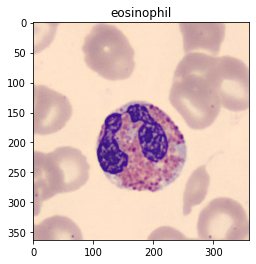

In [28]:
def graph_cell(img, label, memo=""):
    """
    img: a torch.Tensor or a np.ndarray
    label: an integer
    """
    if type(img) == torch.Tensor:
        img = img.detach().cpu().numpy().squeeze()
    img = np.transpose(img.squeeze(), (1, 2, 0))
    plt.imshow(img)
    plt.title((idx2class[label]) + memo)
    plt.show()

for i in range(5):
    img, label = training_data[i]
    graph_cell(img, label.item())

## Convolutional Neural Network
In this section, we will begin creating our neural network architectures.

First, let's gain access to Colab's free GPU. Note, it's limited GPU, so I recommend first using CPU to make sure your model can run without errors. Once all runtime errors have been eliminated, you can turn on GPU to actually train the model. Personally, I like to turn off GPU and let my model run for ONE epoch. That way, I can make sure both my model and my training loops are correct. Another reason as to why you should debug with CPU is because GPU error messages tend to be difficult to interpret, while CPU error messages can point you to exactly where your bug is coming from.

That being said, you can go to Edit > Notebook Settings > and choose "None" or "GPU" under the dropdown menu for Hardware Accelerator.

In [29]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


In the following cell, you will design your own network architecture.

When designing a CNN, it's very good practice to keep track of the dimensions after every layer. During the debug stage, I suggest printing out the output shape while you're coding up your `forward()` and `__init__()` function.

In [30]:
class BloodCell_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        ### YOUR CODE HERE

        # some examples (not an actual architecture - just an example)
        # self.conv = nn.Conv2d(3, 64, 9)
        # self.bn = nn.BatchNorm2d(64)
        # self.max_pool = nn.MaxPool2d(5)

        """
        Define your layers here.
        """
        
        self.conv1 = nn.Conv2d(3, 32, 3) #2D convolutional layer
        self.bn1 = nn.BatchNorm2d(32) #batch normalization 
        self.relu1 = nn.ReLU() #relu to introduce nonlinearity
        self.max_pool1 = nn.MaxPool2d(2) #maxpool to reduce the height and width of the output 

        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.max_pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(236672, 256)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(256, 3)


    def forward(self, X):

        """
        Design the process of your network.
        """

        if len(X.shape) == 3:            # if one single image is passed, make sure it's of dimension (1, 3, H, W)
            X = X.unsqueeze(0)
        
        ### YOUR CODE HERE
        X = self.conv1(X)
        X = self.bn1(X)
        X = self.relu1(X)
        X = self.max_pool1(X)

        X = self.conv2(X)
        X = self.bn2(X)
        X = self.relu2(X)
        X = self.max_pool2(X)

        X = self.conv3(X)
        X = self.bn3(X)
        X = self.relu3(X)
        X = self.max_pool3(X)

        X = X.reshape(X.size(0), -1)

        X = self.fc1(X)
        X = self.relu4(X)

        logits = self.fc2(X)
        
        return logits   # do not apply softmax

    def classify(self, X):
        
        """
        Write a function that outputs the labels.
        """
        ### YOUR CODE HERE
        logits = self.forward(X)
        return torch.argmax(logits, dim=1)

Refer to Homework 5's q2.ipynb and extract certain code from your previous training loop. Do not directly copy and paste the old training loop as there are some things that need to be changed here:

*   You need to send your data to the device we are running the model on like so `x = x.to(device)` where device is what we specified earlier, either CUDA (GPU) or CPU. The things you need to send to the device include the data and the model.
*   When you want to transform your tensor to NumPy, you need to make sure that your tensor is no longer part of the "gradient descent" mechanism and back on the CPU. You can do this by writing `x = x.detach().cpu().numpy()` (yes, it's a bit verbose, but someone reading your code can then very easily understand where the location of your tensors are).
*   Please remove the section where you run your model on the entire training data `X_train` to collect the training accuracy. This is to save memory and speed up the training time. Please save the section where you calculate the validation accuracy though.
*   Implement an early stopping or fall-back technique. Once you realize your model is starting to overfit or plateau, set the model to the iteration when it had the highest validation accuracy. Python's `copy` package is of great use here. In other words, every time a new accuracy is reached, we save that iteration's model weights. At the end of the function, we reset the model to that set of "best weights."


In [31]:
from sklearn.metrics import accuracy_score
from copy import deepcopy

def train(model, training_data, testing_data, epochs=15, batch_size=16, lr=1e-3):
    """
    Q:  write the training loop following the schema shown above.

    Inputs
    - model: the model to be trained - a PyTorch nn.Module class object
    - X_train, y_train, X_val, y_val: training and validation data
    - epochs: num epochs, or the number of times we want to run through the entire training data
    - batch_size: number of data points per batch
    - lr: learning rate
    - optimizer: optimizer used

    Outputs
    - losses: a list of losses
    - accuracies: a list of accuracies
    """

    ### YOUR CODE HERE
    torch.cuda.empty_cache()
    model = model.to(device)

    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=False)          # it's already shuffled

    best_acc = -1
    best_model = None

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    accuracies = []

    for epoch in range(epochs):
        for imgs, labels in iter(train_dataloader):         # check what imgs, labels look like
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(imgs)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            val_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=False)
            val_preds = []
            val_labels = []
            for imgs, labels in iter(val_dataloader):
                imgs = imgs.to(device)
                labels = labels.to(device)
                val_labels.extend(labels.cpu().detach().numpy())
                val_pred = model(imgs).argmax(dim=1).cpu().detach().numpy()
                val_preds.extend(val_pred)
                
        # calculate the validation accuracy and append the loss of this epoch
        accuracy = accuracy_score(val_labels, val_preds)
        losses.append(loss.detach().cpu().numpy())
        accuracies.append(accuracy)

        if accuracy > best_acc:     # implement the fall-back technique mentioned in the description
            best_acc = accuracy
            best_model = deepcopy(model)

        # print epoch, loss, and current test accuracy (don't delete this line - it's slightly more organized now)
        print(f"Epoch {epoch + 1}:\tloss {np.round(loss.detach().cpu().numpy().item(), 4)}\t& accuracy {np.round(accuracy, 4)}")
    print(f"Resetting model... Best validation accuracy:\t{np.round(best_acc, 4)}")
    model.load_state_dict(best_model.state_dict())
    return losses, accuracies

Let's actually train our model now! If one epoch takes too long, feel free to just validate your model's `forward()` method and rerun the notebook with GPU on. Good luck!

For benchmarking, my own model reached 0.80 validation accuracy with the hyperparameters provided. A successful implementation should reach at least a 0.65 accuracy - this is the accuracy the autograder will check.

In [32]:
model = BloodCell_CNN()
losses, accuracies = train(model, training_data, testing_data, batch_size=16, epochs=5)

Epoch 1:	loss 8.6954	& accuracy 0.7347
Epoch 2:	loss 0.8026	& accuracy 0.8367
Epoch 3:	loss 0.0	& accuracy 0.8367
Epoch 4:	loss 0.1908	& accuracy 0.9388
Epoch 5:	loss 0.0	& accuracy 0.9388
Resetting model... Best validation accuracy:	0.9388


In [33]:
#save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/' + "my_model.pt")

Let's plot our predictions! If your model learned well, it should correctly classify all images besides the first one or even better. As someone who is not trained in reading blood cell slides, I have included the prediction of the model and the actual label of the slide in these plots.

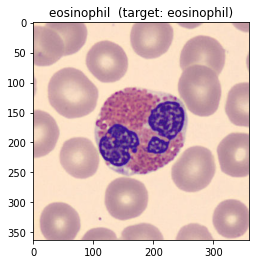

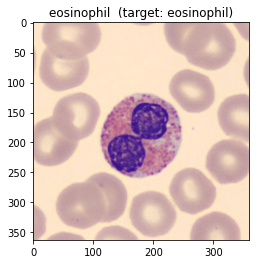

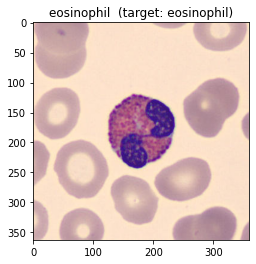

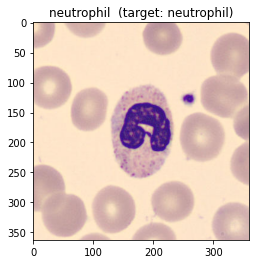

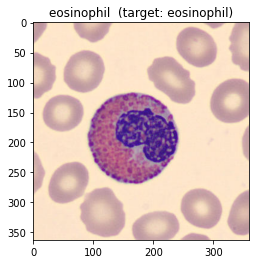

In [34]:
torch.cuda.empty_cache()
imgs = testing_data.tensor_imgs[:5]
labels = testing_data.labels[:5]
preds = model.classify(imgs.to(device))
for i in range(5):
    graph_cell(imgs[i], preds[i].item(), memo=f"  (target: {idx2class[labels[i].numpy().item()]})")

## Generate Predictions

Once you're done with your model training, edit the `test_path` in the following cell and it should generate a list of predictions that you will submit to Gradescope.

In [35]:
# empty some RAM
torch.cuda.empty_cache()
del testing_data
del training_data

test_path = "/content/drive/MyDrive/BIOE245_HW6/bloodcells_dataset/test_data.npy"

test = np.load(test_path)
test = torch.tensor(test).type(torch.float32).to(device)
test = test.permute(0, 3, 1, 2)

# split the hidden test data in half to avoid GPU memory problems
preds1 = model.classify(test[:71])
preds1 = preds1.detach().cpu().numpy()
torch.cuda.empty_cache()
preds2 = model.classify(test[71:])
preds2 = preds2.detach().cpu().numpy()
preds = np.concatenate([preds1.flatten(), preds2.flatten()])
np.save("/content/drive/MyDrive/BIOE245_HW6/predictions.npy", preds)
print("Predictions saved!")

Predictions saved!


Short questions:


1.   What special features did you add to your network? What worked and didn't work?
2.   Describe how we combatted the problem of feeding too much data into the memory and causing a CUDA out of available memory error.

Your answers:

1.   I used the BatchNorm2d() function to incorporate batch normalization into my model. Batch normalization reduces the internal covariate shift by normalizing the inputs in each neural network layer. It also helps with reducing overfitting and increasing accuracy. I also used the MaxPool2d() function. Maxpooling reduces the spacial size of the input and consequentially the complexity of the network. This makes the network more efficient and reduces overfitting as well. 

2.   We combatted the problem of feeding too much data into the memory in many ways. One was through clearing the cache using the code "torch.cuda.empty_cache()". Another was through deleting objects like we deleted *training_data* and *testing_data*. We also split the hidden test data in half to avoid GPU memory problems. Breaking down the big data into half makes it more digestable for the GPU and helps us avoid issues with the memory. 





## Submission

Please submit this file (make sure it has the name `q2.ipynb`), `predictions.npy`, and your model. PLEASE DO NOT submit ANY of the data. I repeat, do not submit any of the data/images used in this project or your autograding process will take forever.

## **Note**: I was unable to submit my model to Gradescope because it was larger than 100 MB. Please let me know if and how I should share the model.